In [1]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import tqdm as tqdm
from cdo import *   # python version
cdo = Cdo()
import csv
import cmocean as cmo
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
import math


osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [23]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
remap_resolution = '360x181'
mesh_file = 'CORE2_finaltopo_mean.nc'
abg = [0, 0, 0]
variable = 'salt'
input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/fesom/","/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom/"
               ]
input_names = ['PICT','HIST']
#input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/fesom/"
#               ]
#input_names = ['SPIN']
years = range(1850, 1860)
reference_path = '/p/project/chhb19/streffing1/postprocessing/climatologies/fdiag/output_awicm3/'
reference_name = 'clim'
reference_years = 1958
figsize=(7,4.3)
#levels = [0, 35, 11]
levels = [-1.5, 1.5, 11]
maxdepth = 6000
units = r'$^\circ$C'
columns = 2
dpi = 500
ofile = "Hovmoeller_temp"
region = "Global Ocean"

In [24]:
# Obtain input names from path if not set explicitly
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [25]:
# Load fesom2 mesh
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [26]:
# Load reference data
path=reference_path+'/'+variable+'.fesom.'+str(reference_years)+'.nc'
data_ref = cdo.yearmean(input='-fldmean -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
data_ref = np.squeeze(data_ref)

In [27]:
# Load model Data
data = OrderedDict()

def load_parallel(variable,path,remap_resolution,meshpath,mesh_file):
    data1 = cdo.yearmean(input='-fldmean -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
    return data1


for exp_path, exp_name  in zip(input_paths, input_names):

    datat = []
    t = []
    temporary = []
    for year in tqdm.tqdm(years):
        path = exp_path+'/'+variable+'.fesom.'+str(year)+'.nc'
        temporary = dask.delayed(load_parallel)(variable,path,remap_resolution,meshpath,mesh_file)
        t.append(temporary)

    with ProgressBar():
        datat = dask.compute(t)
    data[exp_name] = np.squeeze(datat)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 8973.69it/s]

[                                        ] | 0% Completed |  0.1s

[########################################] | 100% Completed |  3.4s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11768.53it/s]

[                                        ] | 0% Completed |  0.1s

[########################################] | 100% Completed |  3.5s


In [28]:
# Read depths from 3D file, since mesh.zlevs is empty..
depths = pd.read_csv(meshpath+'/aux3d.out',  nrows=mesh.nlev) 

In [29]:
# Reshape data and expand reference climatology to length for data in preparation for Hovmöller diagram
data_ref_expand = OrderedDict()
for exp_name  in input_names:
    data[exp_name] = np.flip(np.squeeze(data[exp_name]),axis=1)
    
data_ref_expand = np.tile(data_ref,(np.shape(data[exp_name])[0],1)).T

In [30]:
# Flip data for contourf plot
data_diff = OrderedDict()
for exp_name in input_names:
    data_diff[exp_name]=np.flip(data[exp_name].T,axis=0)-data_ref_expand

In [31]:
# Prepare coordianates for contourf plot
X,Y = np.meshgrid(years,depths[:len(depths)-1])

In [32]:
# Calculate number of rows and columns for plot
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

convert: unable to open image 'Hovmoeller_temp': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `Hovmoeller_temp_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'Hovmoeller_temp_trimmed.png': No such file or directory


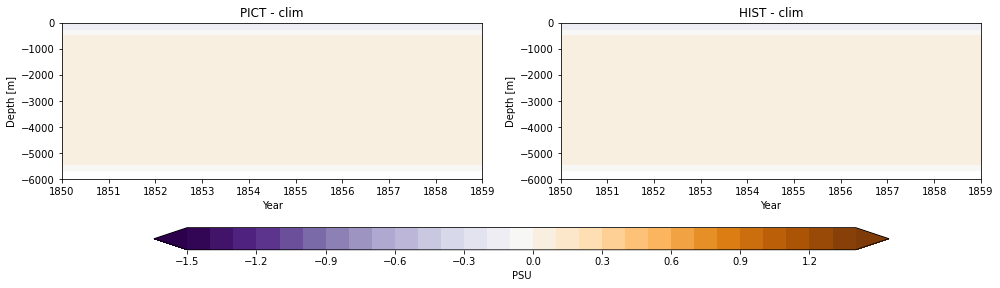

In [33]:
# Plot data and save it.
mapticks = np.arange(levels[0],levels[1],0.1)

nrows, ncols = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize[0]*ncols,figsize[1]*nrows))


if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]


i = 0
for exp_name in data_diff:
    im = axes[i].contourf(X,Y,data_diff[exp_name],levels=mapticks, cmap=cm.PuOr_r, extend='both')
    axes[i].set_title(exp_name+' - '+reference_name)
    axes[i].set_ylabel('Depth [m]')
    axes[i].set_xlabel('Year')
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes[i].set_ylim(-maxdepth)
    #axes[i].set_yscale('symlog')
    i = i+1
fig.tight_layout()

if variable == "temp":
    label='°C'
elif variable == "salt":
    label='PSU'
    
try:
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),location='bottom', label=label, shrink=0.8, aspect=30, pad=0.2)
except:
    cbar = fig.colorbar(im, ax=axes,location='bottom', label=label, shrink=0.8, aspect=25, pad=0.16)



if ofile is not None:
    plt.savefig(ofile, dpi=dpi)
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')

In [34]:
np.flip(data[exp_name].T,axis=0)

array([[ 3.4464439e+01,  3.4466747e+01,  3.4466381e+01,  3.4466679e+01,
         3.4460873e+01,  3.4461422e+01,  3.4458805e+01,  3.4451496e+01,
         3.4456799e+01,  3.4460835e+01],
       [ 3.4474941e+01,  3.4477039e+01,  3.4477375e+01,  3.4477440e+01,
         3.4471889e+01,  3.4472118e+01,  3.4468174e+01,  3.4461216e+01,
         3.4467480e+01,  3.4470291e+01],
       [ 3.4531147e+01,  3.4537144e+01,  3.4536343e+01,  3.4536770e+01,
         3.4527023e+01,  3.4528904e+01,  3.4521957e+01,  3.4516319e+01,
         3.4525333e+01,  3.4529617e+01],
       [ 3.4594082e+01,  3.4603714e+01,  3.4599205e+01,  3.4602577e+01,
         3.4590931e+01,  3.4593670e+01,  3.4584991e+01,  3.4581970e+01,
         3.4590439e+01,  3.4596203e+01],
       [ 3.4187386e+01,  3.4193832e+01,  3.4189476e+01,  3.4192684e+01,
         3.4183765e+01,  3.4185711e+01,  3.4177303e+01,  3.4177425e+01,
         3.4186245e+01,  3.4192036e+01],
       [ 3.4102848e+01,  3.4107662e+01,  3.4105549e+01,  3.4107208e+01,
   